## Set-up environment

Let's start by installing 🤗 Transformers.

In [ ]:
!pip install -q transformers

In [1]:
from transformers import AutoProcessor, AutoModelForUniversalSegmentation

processor = AutoProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")
model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny", is_training=True)

/home/athenaai/anaconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/athenaai/anaconda3/envs/oneformer/lib/python3.8/site-packages/transformers/models/oneformer/image_processing_oneformer.py:446: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.trans

## Dataset Loader and Visualization

In [2]:
import os
import json
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class CustomCocoPanopticDataset(Dataset):
    def __init__(self, data_dir, annotation_file, processor):
        self.data_dir = data_dir
        self.processor = processor

        # Load annotations
        with open(annotation_file, 'r') as f:
            data = json.load(f)
            self.annotations = data['annotations']

        # Ensure each image has a corresponding map and vice versa
        self.image_paths = []
        self.map_paths = []
        for ann in self.annotations:
            image_path = os.path.join(data_dir, 'train2017', ann['file_name'].replace('.png', '.jpg'))
            map_path = os.path.join(data_dir, 'panoptic_train2017', ann['file_name'])

            if os.path.exists(image_path) and os.path.exists(map_path):
                self.image_paths.append(image_path)
                self.map_paths.append(map_path)

        if len(self.image_paths) != len(self.map_paths):
            raise ValueError("Mismatch in the number of images and segmentation maps.")

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        map = Image.open(self.map_paths[idx]).convert('L')
        # map = map.resize(image.size, Image.NEAREST)
        map = np.array(map)

        # Debug print to check before processing
        # print(f"Image type: {type(image)}, map type: {type(map)}")
        # print(f"Image shape: {image.size}, map shape: {map.shape}")

        # Process image and segmentation map
        inputs = self.processor(images=image, segmentation_maps=map, task_inputs=["semantic"], return_tensors="pt")
        inputs = {k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

    def __len__(self):
        return len(self.image_paths)


In [3]:
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx

In [4]:

# dataset = CustomDataset(processor)
dataset = CustomCocoPanopticDataset('panoptic_dataset', 'panoptic_dataset/annotations/instances_train2017.json', processor )

In [5]:
import torch

example = dataset[0]
for k,v in example.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([2, 512, 512])
class_labels torch.Size([2])
text_inputs torch.Size([134, 77])
task_inputs torch.Size([77])


In [6]:
print(processor.tokenizer.batch_decode(example["text_inputs"]))

['<|startoftext|>a photo with a wall <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a photo with a tower <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '<|startoftext|>a semantic photo <

In [7]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
mask_labels torch.Size([1, 2, 512, 512])
class_labels torch.Size([1, 2])
text_inputs torch.Size([1, 134, 77])
task_inputs torch.Size([1, 77])


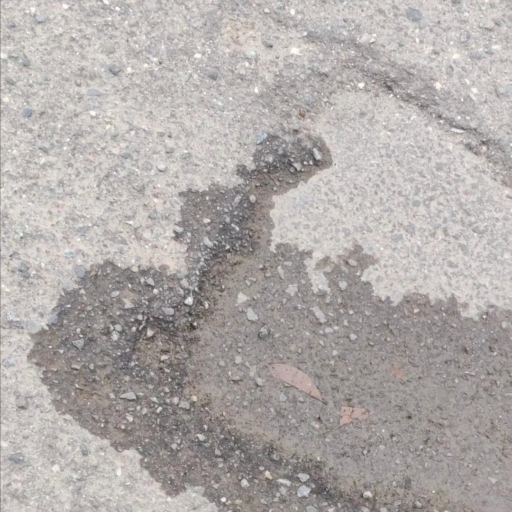

In [9]:
from PIL import Image

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].squeeze().numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

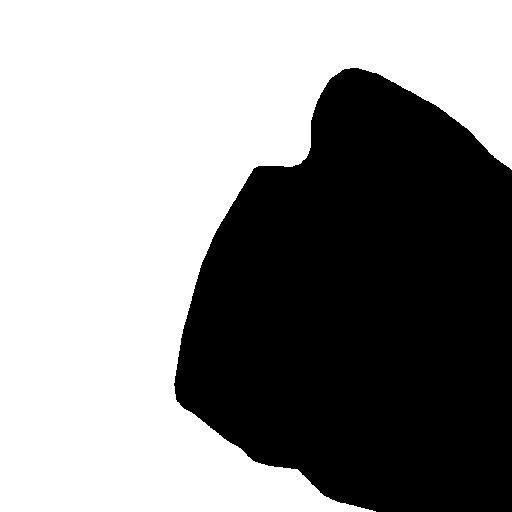

In [10]:
idx = 0

visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

## Train the model

To train the model, we'll use regular PyTorch.

In [15]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()
model.to(device)
for epoch in range(10):  # loop over the dataset multiple times
    for batch in dataloader:

        # zero the parameter gradients
        optimizer.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}

        # forward pass
        outputs = model(**batch)

        # backward pass + optimize
        loss = outputs.loss
        print(f"epoch: {epoch}", "Loss:",loss.item())
        loss.backward()
        optimizer.step()

epoch: 0 Loss: 43.091739654541016
epoch: 0 Loss: 16.37309455871582
epoch: 0 Loss: 54.2274284362793
epoch: 0 Loss: 51.72648239135742
epoch: 0 Loss: 20.35352325439453
epoch: 0 Loss: 31.2635440826416
epoch: 0 Loss: 20.90707778930664
epoch: 0 Loss: 48.84822082519531
epoch: 0 Loss: 54.341190338134766
epoch: 0 Loss: 45.890804290771484
epoch: 0 Loss: 38.527503967285156
epoch: 0 Loss: 26.984228134155273
epoch: 0 Loss: 19.71236801147461
epoch: 0 Loss: 15.57120418548584
epoch: 0 Loss: 23.419208526611328
epoch: 0 Loss: 17.05537223815918
epoch: 0 Loss: 15.485319137573242
epoch: 0 Loss: 24.049423217773438
epoch: 0 Loss: 15.491059303283691
epoch: 0 Loss: 23.770288467407227
epoch: 0 Loss: 29.646644592285156
epoch: 0 Loss: 39.25248336791992
epoch: 0 Loss: 16.362186431884766
epoch: 0 Loss: 15.10731029510498
epoch: 0 Loss: 72.38671112060547
epoch: 0 Loss: 29.918045043945312
epoch: 0 Loss: 21.700908660888672
epoch: 0 Loss: 42.66655731201172
epoch: 0 Loss: 27.80349349975586
epoch: 0 Loss: 28.9175128936767

## Load Model

In [ ]:
# save the model

# model.save_pretrained("oneformer_ade20k_swin_tiny")
# processor.save_pretrained("oneformer_ade20k_swin_tiny")


['oneformer_ade20k_swin_tiny/processor_config.json']

In [1]:
from PIL import Image
import torch

/home/athenaai/anaconda3/envs/oneformer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# load the model and processor

from transformers import AutoProcessor, AutoModelForUniversalSegmentation

processor2 = AutoProcessor.from_pretrained("oneformer_ade20k_swin_tiny")

model2 = AutoModelForUniversalSegmentation.from_pretrained("oneformer_ade20k_swin_tiny")



In [8]:
import cv2
import numpy as np

In [15]:
def oneformer_results(img_path, model, processor):
    # processor = AutoProcessor.from_pretrained("oneformer_ade20k_swin_tiny")
    # model = AutoModelForUniversalSegmentation.from_pretrained("oneformer_ade20k_swin_tiny")
    # model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # this disables the text encoder and hence enables to do forward passes
    # without passing text_inputs
    model.model.is_training = False

    image = Image.open(img_path)
    # prepare image for the model
    inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")

    for k,v in inputs.items():
        if isinstance(v, torch.Tensor):
            print(k,v.shape)

        # forward pass (no need for gradients at inference time)
        with torch.no_grad():
            inputs = inputs.to(device)
            model = model.to(device)
            outputs = model(**inputs)

    # postprocessing
    semantic_segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    semantic_segmentation = semantic_segmentation //69
    # Convert tensor to NumPy array
    binary_mask_np = semantic_segmentation.cpu().numpy().astype(np.uint8)
    print("shape",binary_mask_np.shape, "imagesize:", image.size)
    # Find contours
    contours, _ = cv2.findContours(binary_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes from contours
    # Convert bounding boxes from (x, y, w, h) to (x1, y1, x2, y2)
    bounding_boxes_xyxy = [(x, y, x + w, y + h) for x, y, w, h in (cv2.boundingRect(contour) for contour in contours)]
    print(bounding_boxes_xyxy)
    import matplotlib.pyplot as plt

    # Load and prepare original image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB

    # Draw bounding boxes
    for (x1, y1, x2, y2) in bounding_boxes_xyxy:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image with bounding boxes
    plt.imshow(image)
    plt.show()
    return semantic_segmentation, bounding_boxes_xyxy

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
task_inputs torch.Size([1, 77])
shape (1080, 1080) imagesize: (1080, 1080)
[(273, 0, 936, 914)]


/tmp/ipykernel_22224/2271535247.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  semantic_segmentation = semantic_segmentation //69


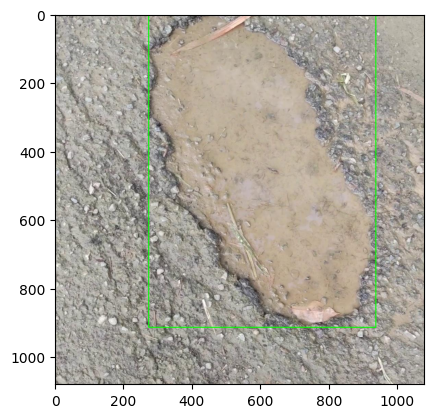

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 [(273, 0, 936, 914)])

In [16]:
img_path = 'panoptic_dataset/val2017/val_2_30_jpg.rf.1b0c4a48e50fcf1fe62ff84d55be77f1.jpg'
oneformer_results(img_path, model2, processor2)

## Inference and Visualization

At inference time, we can perform a forward pass by only providing the pixel values and task inputs to the model.

In [3]:
model2.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

# set is_training attribute of base OneFormerModel to None after training
# this disables the text encoder and hence enables to do forward passes
# without passing text_inputs
model2.model.is_training = False


image = Image.open("panoptic_dataset/val2017/val_0_0_jpg.rf.0e6869d3c5830d8a48349245f0fe845d.jpg")
# prepare image for the model
inputs = processor2(images=image, task_inputs=["semantic"], return_tensors="pt")

for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

# forward pass (no need for gradients at inference time)
with torch.no_grad():
  inputs = inputs.to(device)
  model = model2.to(device)
  outputs = model2(**inputs)

print(outputs.keys())
# postprocessing
semantic_segmentation = processor2.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
semantic_segmentation

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
task_inputs torch.Size([1, 77])
odict_keys(['class_queries_logits', 'masks_queries_logits', 'auxiliary_predictions', 'encoder_hidden_states', 'pixel_decoder_hidden_states', 'transformer_decoder_hidden_states', 'transformer_decoder_object_queries', 'transformer_decoder_contrastive_queries', 'transformer_decoder_mask_predictions', 'transformer_decoder_class_predictions', 'transformer_decoder_auxiliary_predictions', 'task_token', 'attentions'])


/home/athenaai/anaconda3/envs/oneformer/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [6]:
semantic_segmentation = semantic_segmentation //69

/tmp/ipykernel_11048/1504236995.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  semantic_segmentation = semantic_segmentation //69


In [10]:
import numpy as np

# Convert tensor to NumPy array
binary_mask_np = semantic_segmentation.cpu().numpy().astype(np.uint8)


In [11]:
import cv2

# Find contours
contours, _ = cv2.findContours(binary_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract bounding boxes from contours
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]


In [ ]:
def denormalize_bounding_boxes(normalized_bboxes, image_width, image_height):
    denormalized_bboxes = []
    for norm_bbox in normalized_bboxes:
        x_min_norm, y_min_norm, x_max_norm, y_max_norm = norm_bbox
        x_min = x_min_norm * image_width
        y_min = y_min_norm * image_height
        x_max = x_max_norm * image_width
        y_max = y_max_norm * image_height
        denormalized_bboxes.append([x_min, y_min, x_max, y_max])
    return denormalized_bboxes


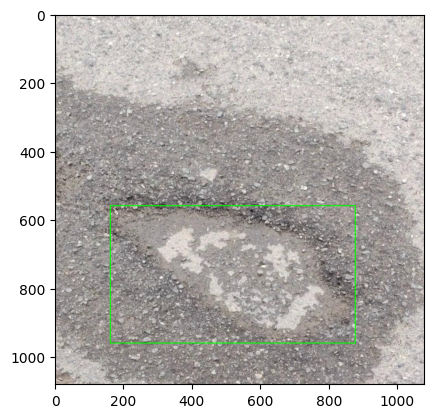

In [14]:
import matplotlib.pyplot as plt

# Load and prepare original image
image = cv2.imread('panoptic_dataset/val2017/val_0_0_jpg.rf.0e6869d3c5830d8a48349245f0fe845d.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB

# Draw bounding boxes
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the image with bounding boxes
plt.imshow(image)
plt.show()


[0, 69]


/tmp/ipykernel_11048/2275468234.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


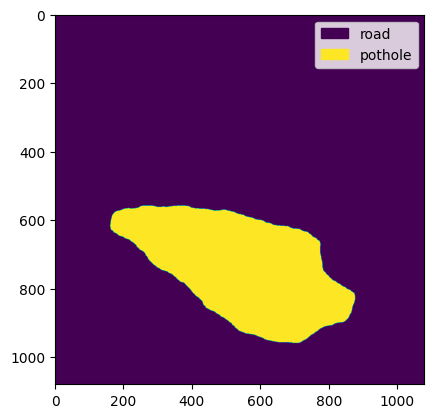

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm


def draw_semantic_segmentation(segmentation):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    # get all the unique numbers
    labels_ids = torch.unique(segmentation).tolist()
    print(labels_ids)
    fig, ax = plt.subplots()
    ax.imshow(segmentation.cpu())
    handles = []
    for label_id in labels_ids:
        label = model.config.id2label[label_id]
        color = viridis(label_id)
        handles.append(mpatches.Patch(color=color, label=label))
    ax.legend(handles=handles)

draw_semantic_segmentation(semantic_segmentation)

Note: the prediction we get here is perfect since the model was already trained on COCO.